# **Rainfall Prediction using Machine Learning**

## **1.Introduction**
---
> **`Objective`** :  
The primary objective of this project is to develop a machine learning model that can accurately predict rainfall based on historical weather data. By using various data preprocessing techniques and exploring different machine learning algorithms, the goal is to create a model that can help in forecasting rainfall patterns. This can be particularly useful for agriculture, water resource management, and disaster preparedness.

### **1.1 Importing dependencies**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,TargetEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.utils import resample
from sklearn.svm import SVC,SVR
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score,precision_score,accuracy_score,precision_recall_curve


## **2. Data_Collection & Formatting**
 > ### **`source`** : Kaggle
 [Data_set](https://www.kaggle.com/datasets/hiteshsoneji/historical-weather-data-for-indian-cities)


### **2.1 Downloading The Data**

In [2]:
dataset_dir = os.path.join(os.getcwd(), "Datasets")
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

exit_code = os.system(
    f"kaggle datasets download hiteshsoneji/historical-weather-data-for-indian-cities -p {dataset_dir} --unzip"
)

if exit_code == 0:
    print("Dataset successfully downloaded and extracted.")
else:
    print("Failed to download the dataset. Please check your Kaggle API setup.")


Dataset successfully downloaded and extracted.


**Note:** We will only use Hyderabad's Data in this project and also the data is on hourly basis we will convert the data to day-wise basis

### **2.2 Formatting the Data**

In [3]:
full_data = pd.read_csv("Datasets/hyderabad.csv",parse_dates=[0],index_col=[0])
full_data.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
date_time,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,06:46 AM,...,21,9,0,83,0.0,1013,16,10,150,6
2009-01-01 01:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,06:46 AM,...,20,9,0,85,0.0,1013,16,10,148,5
2009-01-01 02:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,06:46 AM,...,20,8,0,86,0.0,1013,15,10,147,5
2009-01-01 03:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,06:46 AM,...,19,8,0,88,0.0,1013,15,10,145,5
2009-01-01 04:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,06:46 AM,...,21,7,0,80,0.0,1014,16,10,148,5


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2009-01-01 00:00:00 to 2020-01-01 23:00:00
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   maxtempC           96432 non-null  int64  
 1   mintempC           96432 non-null  int64  
 2   totalSnow_cm       96432 non-null  float64
 3   sunHour            96432 non-null  float64
 4   uvIndex            96432 non-null  int64  
 5   uvIndex.1          96432 non-null  int64  
 6   moon_illumination  96432 non-null  int64  
 7   moonrise           96432 non-null  object 
 8   moonset            96432 non-null  object 
 9   sunrise            96432 non-null  object 
 10  sunset             96432 non-null  object 
 11  DewPointC          96432 non-null  int64  
 12  FeelsLikeC         96432 non-null  int64  
 13  HeatIndexC         96432 non-null  int64  
 14  WindChillC         96432 non-null  int64  
 15  WindGustKmph       96432 non-null  

In [5]:
full_data["totalSnow_cm"].value_counts()

totalSnow_cm
0.0    96432
Name: count, dtype: int64

In [6]:
full_data.drop(["moonrise","moonset","sunrise","sunset","uvIndex.1","totalSnow_cm"],inplace=True,axis=1)

In [7]:
full_data.columns

Index(['maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'moon_illumination',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [8]:
# First create the daily aggregation as before
daily_data = full_data.resample('D').agg({
    'maxtempC': 'max',
    'mintempC': 'min',
    'precipMM': 'sum',
    'sunHour': 'sum',
    'uvIndex': 'mean',
    'moon_illumination': 'mean',
    'DewPointC': 'mean',
    'FeelsLikeC': 'mean',
    'HeatIndexC': 'mean',
    'WindChillC': 'mean',
    'WindGustKmph': 'mean',
    'cloudcover': 'mean',
    'humidity': 'mean',
    'pressure': 'mean',
    'tempC': 'mean',
    'visibility': 'mean',
    'winddirDegree': 'mean',
    'windspeedKmph': 'mean'
})

# Define first half and second half of the day
first_half = full_data.between_time('00:00', '11:59')
second_half = full_data.between_time('12:00', '23:59')

# Create first half and second half aggregations for important features
important_features = ['tempC', 'humidity', 'windspeedKmph', 'winddirDegree', 'cloudcover']

for feature in important_features:
    # First half aggregations
    first_half_agg = first_half[feature].resample('D').mean()
    daily_data[f'{feature}_first_half'] = first_half_agg
    
    # Second half aggregations
    second_half_agg = second_half[feature].resample('D').mean()
    daily_data[f'{feature}_second_half'] = second_half_agg
    
daily_data = daily_data.drop(columns=important_features)

for col in daily_data.columns:
    daily_data[col] = daily_data[col].round(2).astype(dtype="float32")


In [9]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2009-01-01 to 2020-01-01
Freq: D
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   maxtempC                   4018 non-null   float32
 1   mintempC                   4018 non-null   float32
 2   precipMM                   4018 non-null   float32
 3   sunHour                    4018 non-null   float32
 4   uvIndex                    4018 non-null   float32
 5   moon_illumination          4018 non-null   float32
 6   DewPointC                  4018 non-null   float32
 7   FeelsLikeC                 4018 non-null   float32
 8   HeatIndexC                 4018 non-null   float32
 9   WindChillC                 4018 non-null   float32
 10  WindGustKmph               4018 non-null   float32
 11  pressure                   4018 non-null   float32
 12  visibility                 4018 non-null   float32
 13  tempC_first_half      

In [10]:
# Save the day-wise data to a CSV file
file_name = "Datasets/day_wise_hyderabad.csv"
daily_data.to_csv(file_name, index=True)

In [11]:
daily_data["Raintoday"] = daily_data['precipMM'].apply(lambda x: 'Yes' if x >= 0.1 else 'No')
daily_data["Raintomorrow"] = daily_data['Raintoday'].shift(-1)

def categorize_rain(x):
    if x < 0.1:
        return 'No Rain'
    elif x >= 0.1 and x < 11 :
        return 'Light Rain'
    elif x >= 11 and x < 31:
        return 'Moderate Rain'
    else:
        return 'Heavy Rain'

daily_data['RainCategory'] = daily_data['precipMM'].apply(categorize_rain)
daily_data["RainCategorytomorrow"] = daily_data['RainCategory'].shift(-1)


In [12]:
daily_data.head()

,maxtempC,mintempC,precipMM,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,windspeedKmph_first_half,windspeedKmph_second_half,winddirDegree_first_half,winddirDegree_second_half,cloudcover_first_half,cloudcover_second_half,Raintoday,Raintomorrow,RainCategory,RainCategorytomorrow
date_time,,,,,,,,,,,,,,,,,,,,,
2009-01-01,28.0,15.0,0.0,208.800003,6.0,31.0,13.42,23.420000,23.540001,23.420000,...,5.83,10.17,133.830002,85.169998,0.42,3.33,No,No,No Rain,No Rain
2009-01-02,28.0,16.0,0.0,208.800003,6.0,38.0,13.75,22.959999,23.120001,22.830000,...,8.25,9.50,119.830002,95.750000,2.25,9.83,No,No,No Rain,No Rain
2009-01-03,27.0,16.0,0.0,208.800003,6.0,45.0,15.04,21.830000,21.830000,21.580000,...,9.42,10.58,126.830002,135.500000,13.58,15.33,No,No,No Rain,No Rain
2009-01-04,28.0,16.0,0.0,208.800003,6.0,52.0,14.00,22.750000,23.250000,22.620001,...,7.17,9.00,142.830002,130.080002,5.83,5.50,No,No,No Rain,No Rain
2009-01-05,28.0,15.0,0.0,208.800003,6.0,60.0,12.00,23.000000,23.120001,23.250000,...,8.00,11.08,163.330002,134.330002,0.83,2.83,No,No,No Rain,No Rain


In [13]:
daily_data = daily_data.dropna()

In [14]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2009-01-01 to 2019-12-31
Freq: D
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   maxtempC                   4017 non-null   float32
 1   mintempC                   4017 non-null   float32
 2   precipMM                   4017 non-null   float32
 3   sunHour                    4017 non-null   float32
 4   uvIndex                    4017 non-null   float32
 5   moon_illumination          4017 non-null   float32
 6   DewPointC                  4017 non-null   float32
 7   FeelsLikeC                 4017 non-null   float32
 8   HeatIndexC                 4017 non-null   float32
 9   WindChillC                 4017 non-null   float32
 10  WindGustKmph               4017 non-null   float32
 11  pressure                   4017 non-null   float32
 12  visibility                 4017 non-null   float32
 13  tempC_first_half      

## **3. Data_Preprocessing**

In [15]:
daily_data['Raintoday'] = daily_data['Raintoday'].replace({'No': 0, 'Yes': 1})
daily_data['Raintomorrow'] = daily_data['Raintomorrow'].replace({'No': 0, 'Yes': 1})

C:\Users\yashw\AppData\Local\Temp\ipykernel_26752\3873075406.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_data['Raintoday'] = daily_data['Raintoday'].replace({'No': 0, 'Yes': 1})
C:\Users\yashw\AppData\Local\Temp\ipykernel_26752\3873075406.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_data['Raintomorrow'] = daily_data['Raintomorrow'].replace({'No': 0, 'Yes': 1})


In [16]:
daily_data['RainCategorytomorrow'].value_counts()

RainCategorytomorrow
No Rain          2602
Light Rain       1282
Moderate Rain     114
Heavy Rain         19
Name: count, dtype: int64

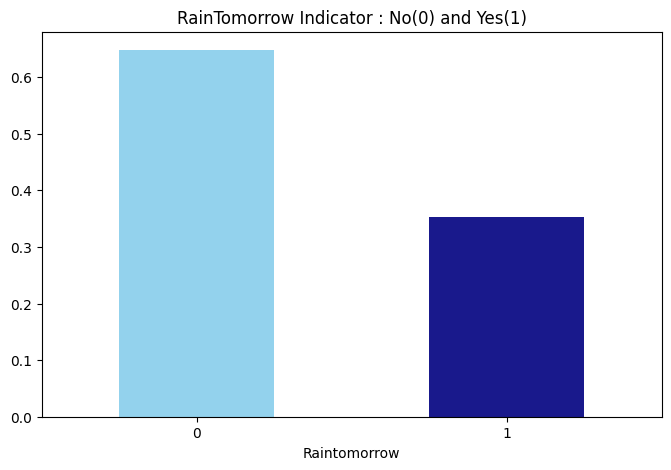

In [17]:
fig = plt.figure(figsize = (8,5))
daily_data['Raintomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator : No(0) and Yes(1)')
plt.show()

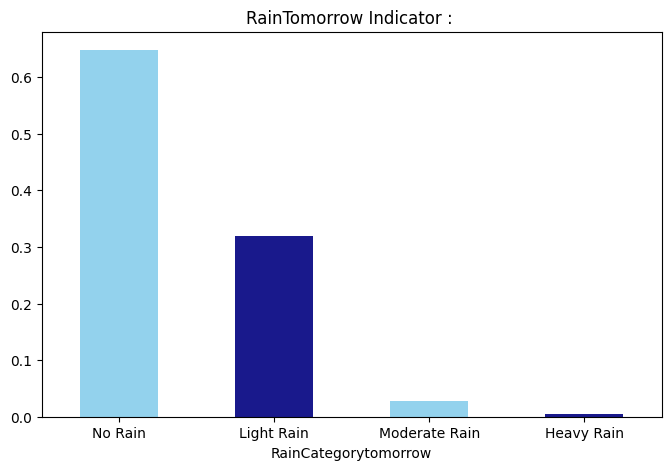

In [18]:
fig = plt.figure(figsize = (8,5))
daily_data['RainCategorytomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator : ')
plt.show()

### **3.1 Feature modification**

In [19]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2009-01-01 to 2019-12-31
Freq: D
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   maxtempC                   4017 non-null   float32
 1   mintempC                   4017 non-null   float32
 2   precipMM                   4017 non-null   float32
 3   sunHour                    4017 non-null   float32
 4   uvIndex                    4017 non-null   float32
 5   moon_illumination          4017 non-null   float32
 6   DewPointC                  4017 non-null   float32
 7   FeelsLikeC                 4017 non-null   float32
 8   HeatIndexC                 4017 non-null   float32
 9   WindChillC                 4017 non-null   float32
 10  WindGustKmph               4017 non-null   float32
 11  pressure                   4017 non-null   float32
 12  visibility                 4017 non-null   float32
 13  tempC_first_half      

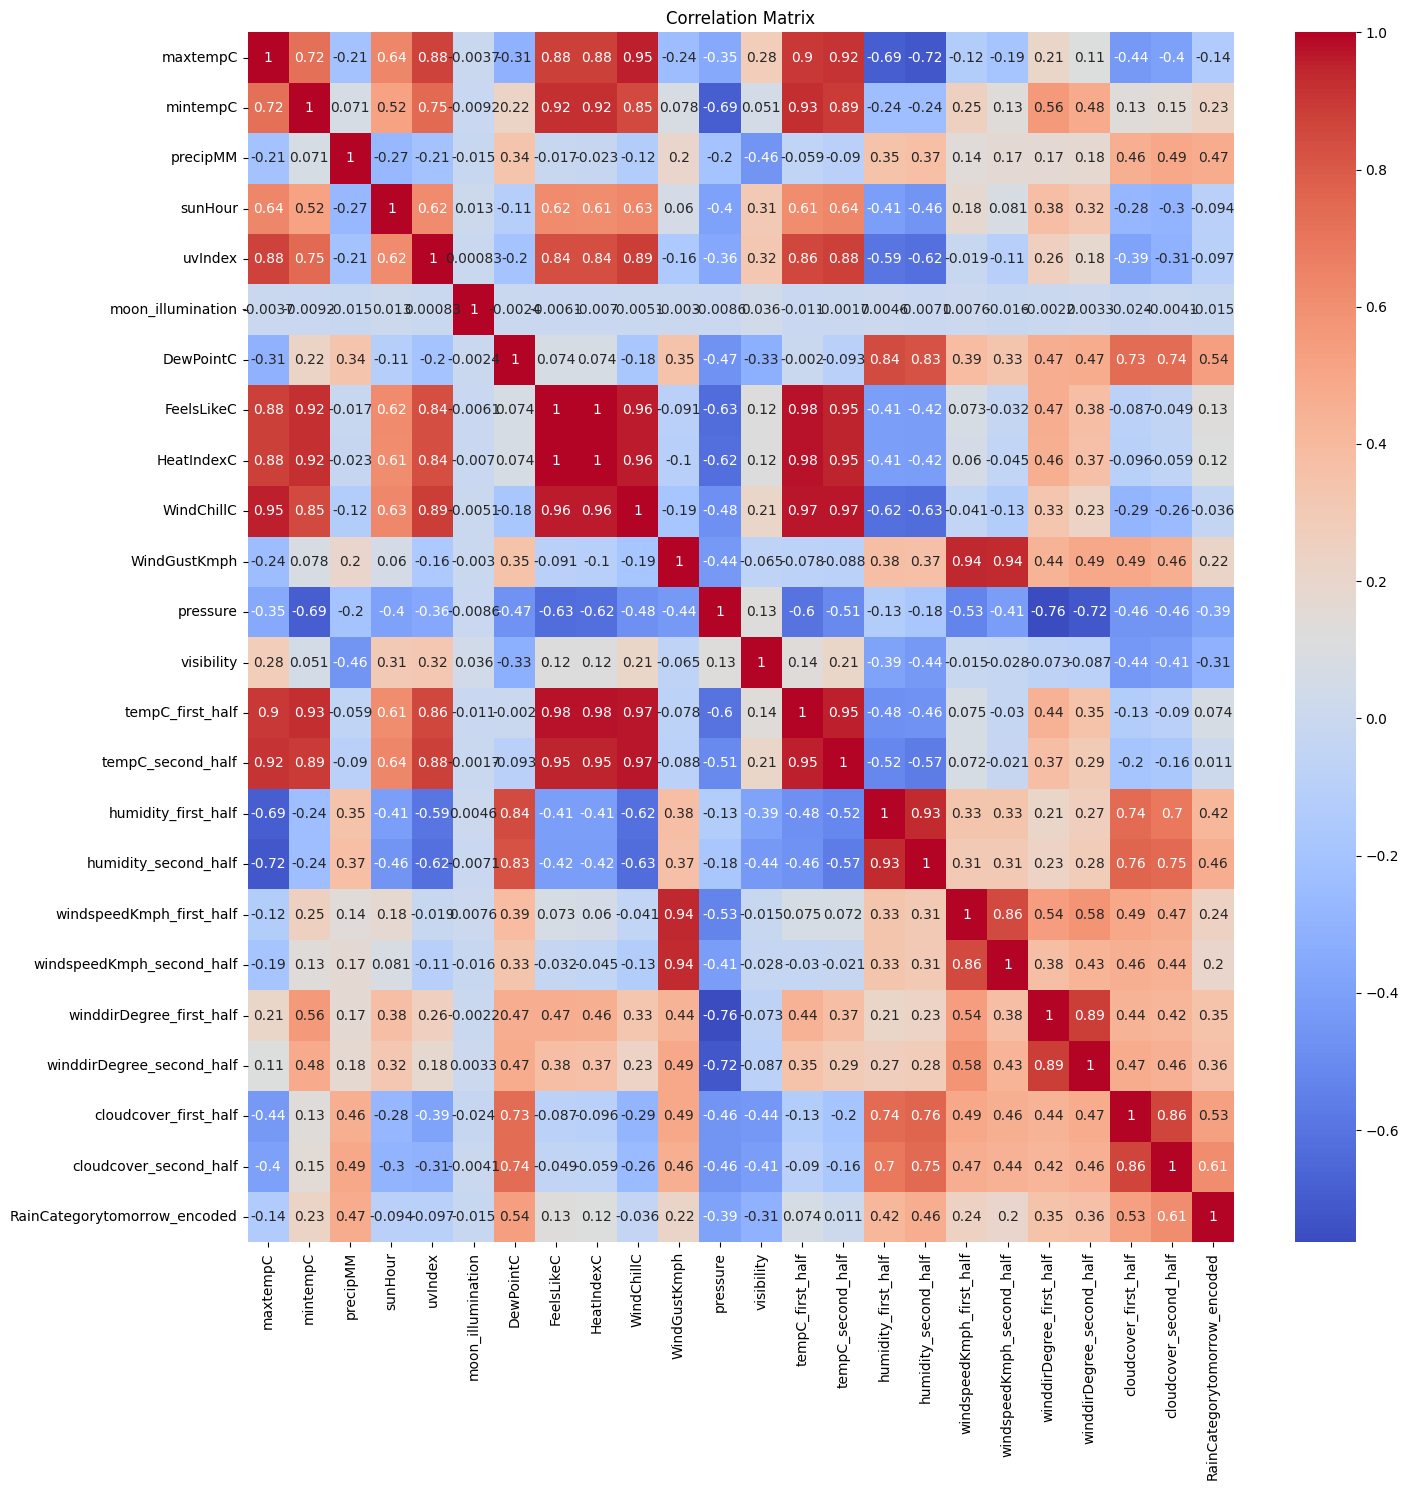

In [20]:
X = daily_data.drop(['Raintomorrow', 'RainCategory', 'Raintoday', 'RainCategorytomorrow'], axis=1)
category_mapping = {'No Rain': 0, 'Light Rain': 1, 'Moderate Rain': 2, 'Heavy Rain': 3}
y = daily_data['RainCategorytomorrow'].map(category_mapping)
correlation_df = X.copy()
correlation_df['RainCategorytomorrow_encoded'] = y
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [21]:
# Enhanced Feature Engineering - ADD THIS AFTER YOUR CORRELATION HEATMAP
def create_advanced_features(df):
    df_enhanced = df.copy()
    
    # 1. Temporal Features
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    df_enhanced['season'] = df_enhanced['month'].map({
        12: 0, 1: 0, 2: 0,  # Winter
        3: 1, 4: 1, 5: 1,   # Spring  
        6: 2, 7: 2, 8: 2,   # Summer
        9: 3, 10: 3, 11: 3  # Autumn
    })
    
    # 2. Lag Features (Previous day weather)
    for col in ['precipMM', 'maxtempC', 'mintempC', 'humidity_first_half', 'pressure']:
        df_enhanced[f'{col}_lag1'] = df_enhanced[col].shift(1)
    
    # 3. Rolling Features (3-day moving averages)
    for col in ['maxtempC', 'mintempC', 'pressure', 'humidity_first_half']:
        df_enhanced[f'{col}_rolling_3d'] = df_enhanced[col].rolling(window=3).mean()
    
    # 4. Derived Weather Features
    df_enhanced['temp_range'] = df_enhanced['maxtempC'] - df_enhanced['mintempC']
    df_enhanced['humidity_change'] = df_enhanced['humidity_first_half'] - df_enhanced['humidity_second_half']
    df_enhanced['wind_change'] = df_enhanced['windspeedKmph_first_half'] - df_enhanced['windspeedKmph_second_half']
    
    # 5. Interaction Features
    df_enhanced['temp_humidity_interaction'] = df_enhanced['maxtempC'] * df_enhanced['humidity_first_half'] / 100
    df_enhanced['pressure_temp_interaction'] = df_enhanced['pressure'] * df_enhanced['maxtempC'] / 1000
    
    return df_enhanced

# Apply enhanced feature engineering
daily_data = create_advanced_features(daily_data)
print("Enhanced daily_data shape:", daily_data.shape)

Enhanced daily_data shape: (4017, 44)


In [22]:
# Dropping moon_illumination have very low corelation with all features including target varaible
# Dropping FeelsLikeC and HeatIndexC both corelation =1 and also very low corelation with target
# Dropping WindChillC - Highly correlated with other temperature features
# Remove highly correlated and low-value features, keep new engineered features
features_to_drop = ['moon_illumination', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 
                    'Raintoday', 'RainCategorytomorrow', 'RainCategory']

modified = daily_data.drop(features_to_drop, axis=1)

# Remove rows with NaN values created by lag/rolling features
modified = modified.dropna()

X = modified.drop(['Raintomorrow'],axis = 1)
y = modified['Raintomorrow']

print("Enhanced X shape:", X.shape)
print("New features added:", X.shape[1] - 19)

Enhanced X shape: (4015, 36)
New features added: 17


In [23]:
split_idx = int(len(modified) * 0.8)
split_date = modified.index[split_idx]

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("train-test split:")
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
print(f"Split date: {split_date}")

train-test split:
X_train.shape: (3212, 36), X_test.shape: (803, 36)
Split date: 2017-10-20 00:00:00


In [24]:
X_train.shape,X_test.shape

((3212, 36), (803, 36))

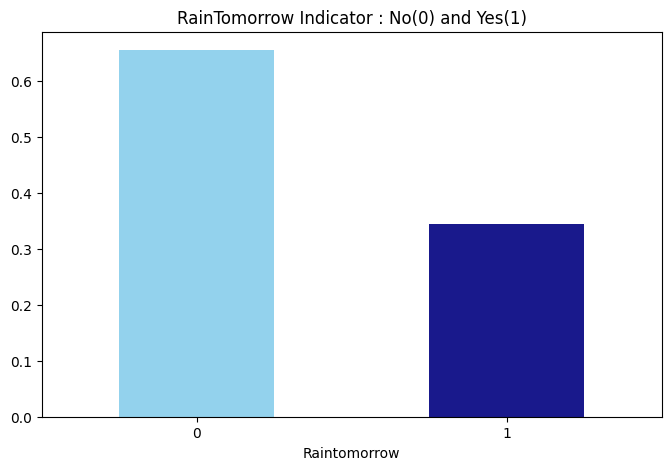

In [25]:
fig = plt.figure(figsize = (8,5))
y_train.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator : No(0) and Yes(1)')
plt.show()

In [26]:
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("After SMOTETomek:")
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"Class distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")

# Feature selection using mutual information
feature_selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_selected = feature_selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = feature_selector.transform(X_test)

print(f"Selected features: {X_train_selected.shape[1]} out of {X_train_resampled.shape[1]}")

C:\Users\yashw\miniconda3\envs\tf210\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\yashw\miniconda3\envs\tf210\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\yashw\miniconda3\envs\tf210\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTETomek:
X_train_resampled shape: (4098, 36)
Class distribution: {0: 2049, 1: 2049}
Selected features: 20 out of 36


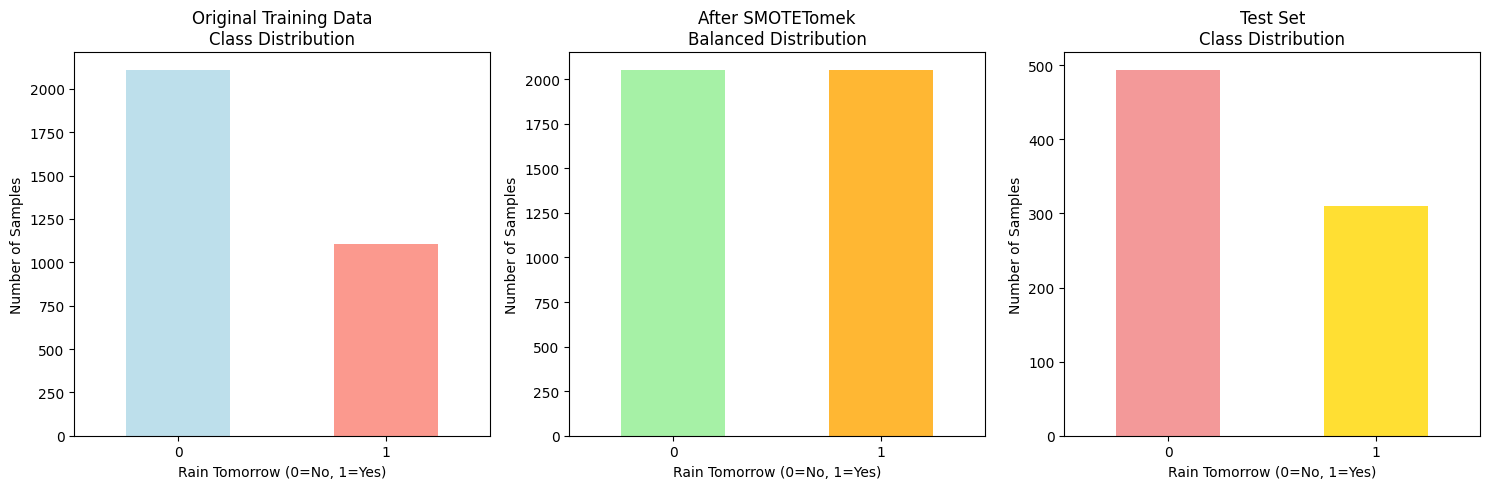

=== CLASS DISTRIBUTION ANALYSIS ===
Original Training Set:
  No Rain (0): 2,107 samples (65.6%)
  Rain (1): 1,105 samples (34.4%)
  Total: 3,212 samples
  Imbalance Ratio: 1.9:1

After SMOTETomek Balancing:
  No Rain (0): 2,049 samples (50.0%)
  Rain (1): 2,049 samples (50.0%)
  Total: 4,098 samples
  Improvement: Added 886 samples


In [27]:

# 1. Class Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'], alpha=0.8)
axes[0].set_title('Original Training Data\nClass Distribution')
axes[0].set_xlabel('Rain Tomorrow (0=No, 1=Yes)')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=0)

# After SMOTETomek balancing
pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'orange'], alpha=0.8)
axes[1].set_title('After SMOTETomek\nBalanced Distribution')
axes[1].set_xlabel('Rain Tomorrow (0=No, 1=Yes)')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=0)

# Test set distribution (unchanged)
y_test.value_counts().plot(kind='bar', ax=axes[2], color=['lightcoral', 'gold'], alpha=0.8)
axes[2].set_title('Test Set\nClass Distribution')
axes[2].set_xlabel('Rain Tomorrow (0=No, 1=Yes)')
axes[2].set_ylabel('Number of Samples')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== CLASS DISTRIBUTION ANALYSIS ===")
print(f"Original Training Set:")
print(f"  No Rain (0): {(y_train == 0).sum():,} samples ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Rain (1): {(y_train == 1).sum():,} samples ({(y_train == 1).mean()*100:.1f}%)")
print(f"  Total: {len(y_train):,} samples")
print(f"  Imbalance Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

print(f"\nAfter SMOTETomek Balancing:")
print(f"  No Rain (0): {(pd.Series(y_train_resampled) == 0).sum():,} samples ({(pd.Series(y_train_resampled) == 0).mean()*100:.1f}%)")
print(f"  Rain (1): {(pd.Series(y_train_resampled) == 1).sum():,} samples ({(pd.Series(y_train_resampled) == 1).mean()*100:.1f}%)")
print(f"  Total: {len(y_train_resampled):,} samples")
print(f"  Improvement: Added {len(y_train_resampled) - len(y_train):,} samples")


=== FEATURE SELECTION ANALYSIS ===
Original Features: 36
Selected Features: 20
Features Removed: 16


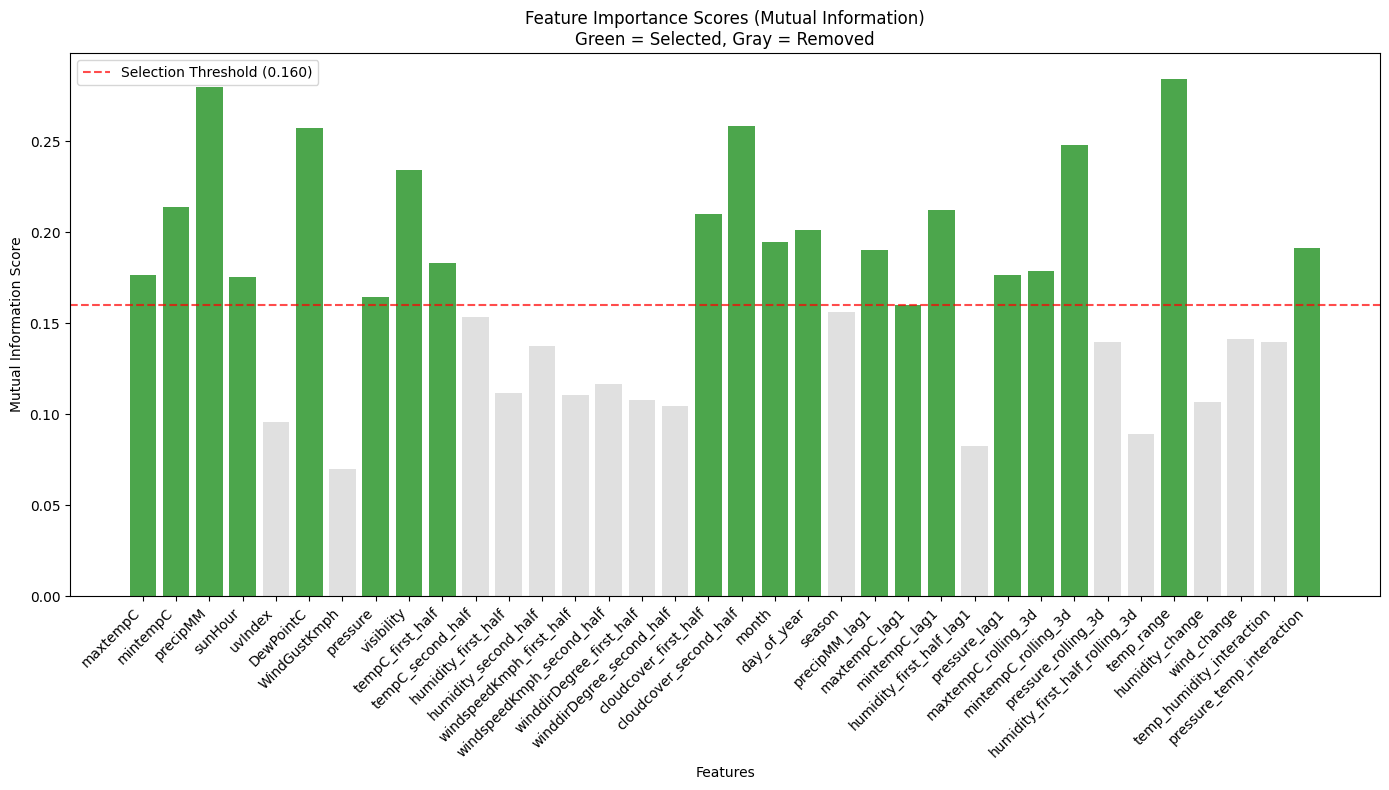


Top 10 Selected Features:
 1. temp_range                     Score: 0.2841
 2. precipMM                       Score: 0.2797
 3. cloudcover_second_half         Score: 0.2584
 4. DewPointC                      Score: 0.2573
 5. mintempC_rolling_3d            Score: 0.2479
 6. visibility                     Score: 0.2343
 7. mintempC                       Score: 0.2140
 8. mintempC_lag1                  Score: 0.2121
 9. cloudcover_first_half          Score: 0.2098
10. day_of_year                    Score: 0.2014

Bottom 5 Selected Features:
16. pressure_lag1                  Score: 0.1765
17. maxtempC                       Score: 0.1765
18. sunHour                        Score: 0.1754
19. pressure                       Score: 0.1643
20. maxtempC_lag1                  Score: 0.1602


In [28]:
# 2. Feature Selection Analysis
print("\n=== FEATURE SELECTION ANALYSIS ===")
print(f"Original Features: {X_train_resampled.shape[1]}")
print(f"Selected Features: {X_train_selected.shape[1]}")
print(f"Features Removed: {X_train_resampled.shape[1] - X_train_selected.shape[1]}")

# Get feature importance scores and names
feature_scores = feature_selector.scores_
selected_mask = feature_selector.get_support()

# Create feature importance visualization
plt.figure(figsize=(14, 8))

# Plot all features with selected ones highlighted
x_pos = np.arange(len(feature_scores))
colors = ['green' if selected else 'lightgray' for selected in selected_mask]

bars = plt.bar(x_pos, feature_scores, color=colors, alpha=0.7)
plt.title('Feature Importance Scores (Mutual Information)\nGreen = Selected, Gray = Removed')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.xticks(x_pos, X.columns, rotation=45, ha='right')

# Add threshold line
threshold = sorted(feature_scores, reverse=True)[19]  # 20th highest score
plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
           label=f'Selection Threshold ({threshold:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

# Print top selected features
selected_features = X.columns[selected_mask]
selected_scores = feature_scores[selected_mask]
feature_ranking = sorted(zip(selected_features, selected_scores), 
                        key=lambda x: x[1], reverse=True)

print(f"\nTop 10 Selected Features:")
for i, (feature, score) in enumerate(feature_ranking[:10], 1):
    print(f"{i:2d}. {feature:<30} Score: {score:.4f}")

print(f"\nBottom 5 Selected Features:")
for i, (feature, score) in enumerate(feature_ranking[-5:], 16):
    print(f"{i:2d}. {feature:<30} Score: {score:.4f}")


=== FEATURE ENGINEERING IMPACT ===
Original Weather Features:
  Available: 19
  Selected: 10 (52.6%)

Engineered Features:
  Created: 17
  Selected: 10 (58.8%)

Engineered Feature Types:
  Temporal: 2/3 selected (67%)
  Lag: 4/5 selected (80%)
  Rolling: 2/4 selected (50%)
  Derived: 1/3 selected (33%)
  Interaction: 1/2 selected (50%)


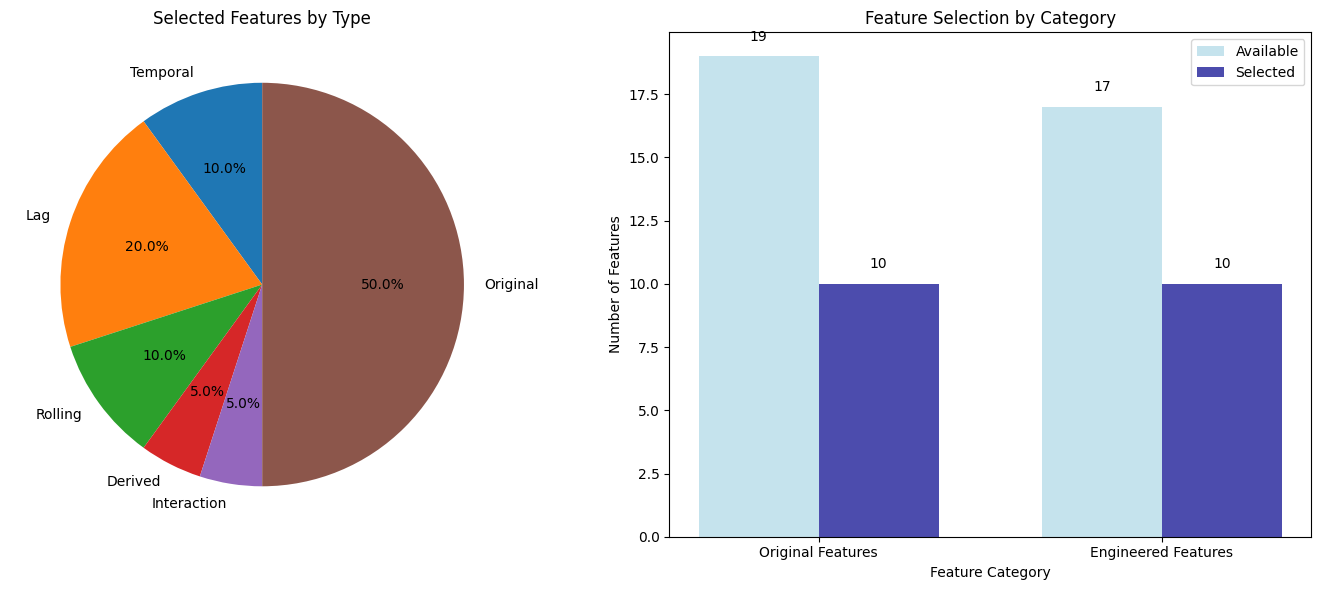

In [29]:
# 3. Feature Engineering Impact Analysis
print("\n=== FEATURE ENGINEERING IMPACT ===")

# Categorize features by type
original_features = ['maxtempC', 'mintempC', 'precipMM', 'sunHour', 'uvIndex', 'DewPointC', 
                    'WindGustKmph', 'pressure', 'visibility', 'tempC_first_half', 'tempC_second_half',
                    'humidity_first_half', 'humidity_second_half', 'windspeedKmph_first_half', 
                    'windspeedKmph_second_half', 'winddirDegree_first_half', 'winddirDegree_second_half',
                    'cloudcover_first_half', 'cloudcover_second_half']

engineered_features = [f for f in X.columns if f not in original_features]

# Count selected features by type
selected_original = len([f for f in selected_features if f in original_features])
selected_engineered = len([f for f in selected_features if f in engineered_features])

print(f"Original Weather Features:")
print(f"  Available: {len(original_features)}")
print(f"  Selected: {selected_original} ({selected_original/len(original_features)*100:.1f}%)")

print(f"\nEngineered Features:")
print(f"  Created: {len(engineered_features)}")
print(f"  Selected: {selected_engineered} ({selected_engineered/len(engineered_features)*100:.1f}%)")

# Feature type analysis
feature_types = {
    'Temporal': [f for f in engineered_features if any(x in f for x in ['month', 'day_of_year', 'season'])],
    'Lag': [f for f in engineered_features if 'lag' in f],
    'Rolling': [f for f in engineered_features if 'rolling' in f],
    'Derived': [f for f in engineered_features if any(x in f for x in ['range', 'change'])],
    'Interaction': [f for f in engineered_features if 'interaction' in f]
}

print(f"\nEngineered Feature Types:")
for ftype, features in feature_types.items():
    selected_count = len([f for f in features if f in selected_features])
    if len(features) > 0:
        print(f"  {ftype}: {selected_count}/{len(features)} selected ({selected_count/len(features)*100:.0f}%)")

# Visualize feature types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart of selected feature types
type_counts = []
type_labels = []
for ftype, features in feature_types.items():
    count = len([f for f in features if f in selected_features])
    if count > 0:
        type_counts.append(count)
        type_labels.append(ftype)

# Add original features
original_selected = len([f for f in selected_features if f in original_features])
if original_selected > 0:
    type_counts.append(original_selected)
    type_labels.append('Original')

ax1.pie(type_counts, labels=type_labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Selected Features by Type')

# Bar chart comparison
categories = ['Original Features', 'Engineered Features']
available = [len(original_features), len(engineered_features)]
selected = [selected_original, selected_engineered]

x = np.arange(len(categories))
width = 0.35

ax2.bar(x - width/2, available, width, label='Available', alpha=0.7, color='lightblue')
ax2.bar(x + width/2, selected, width, label='Selected', alpha=0.7, color='darkblue')

ax2.set_xlabel('Feature Category')
ax2.set_ylabel('Number of Features')
ax2.set_title('Feature Selection by Category')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()

# Add value labels on bars
for i, (avail, sel) in enumerate(zip(available, selected)):
    ax2.text(i - width/2, avail + 0.5, str(avail), ha='center', va='bottom')
    ax2.text(i + width/2, sel + 0.5, str(sel), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [30]:
# Convert selected features back to DataFrame for analysis
selected_feature_names = X.columns[feature_selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

X_train_selected_df.describe()

,maxtempC,mintempC,precipMM,sunHour,DewPointC,pressure,visibility,tempC_first_half,cloudcover_first_half,cloudcover_second_half,month,day_of_year,precipMM_lag1,maxtempC_lag1,mintempC_lag1,pressure_lag1,maxtempC_rolling_3d,mintempC_rolling_3d,temp_range,pressure_temp_interaction
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,31.663607,22.094695,1.228597,261.022758,15.970654,1007.835445,9.676891,26.069810,29.440589,28.964200,6.573694,185.630307,1.140769,31.728667,22.092725,1007.855176,31.721667,22.089767,9.568912,31.906504
std,4.347111,3.993949,3.002966,47.473353,5.195488,4.206542,0.705032,3.865990,26.665889,24.756802,3.175305,97.363949,2.853697,4.304790,4.012201,4.187649,4.166723,3.952018,3.358351,4.339276
min,20.000000,10.000000,0.000000,100.800003,-4.420000,998.169983,2.380000,16.500000,0.000000,0.000000,1.000000,1.000000,0.000000,20.000000,10.000000,998.250000,23.000000,11.000000,1.000000,20.266600
25%,29.000000,19.000000,0.000000,208.800003,12.080709,1004.325989,9.750000,23.420000,5.678313,6.330000,4.000000,109.000000,0.000000,29.000000,19.000000,1004.380005,28.666667,19.333333,7.000000,29.093090
50%,31.000000,22.000000,0.000000,278.399994,17.270000,1007.202087,10.000000,25.580000,22.830000,25.161854,7.000000,190.000000,0.000000,31.000000,22.000000,1007.178680,30.666667,22.333333,10.000000,31.106640
75%,34.000000,24.450565,0.969382,307.200012,20.420000,1011.551514,10.000000,28.080000,48.669998,45.676601,9.000000,262.000000,0.900000,34.000000,24.489736,1011.539978,34.333333,24.416130,12.000000,34.379696
max,45.000000,33.000000,37.599998,314.399994,24.080000,1019.250000,10.000000,37.080002,100.000000,100.000000,12.000000,366.000000,37.599998,45.000000,33.000000,1019.250000,44.333333,32.666667,20.000000,45.129601


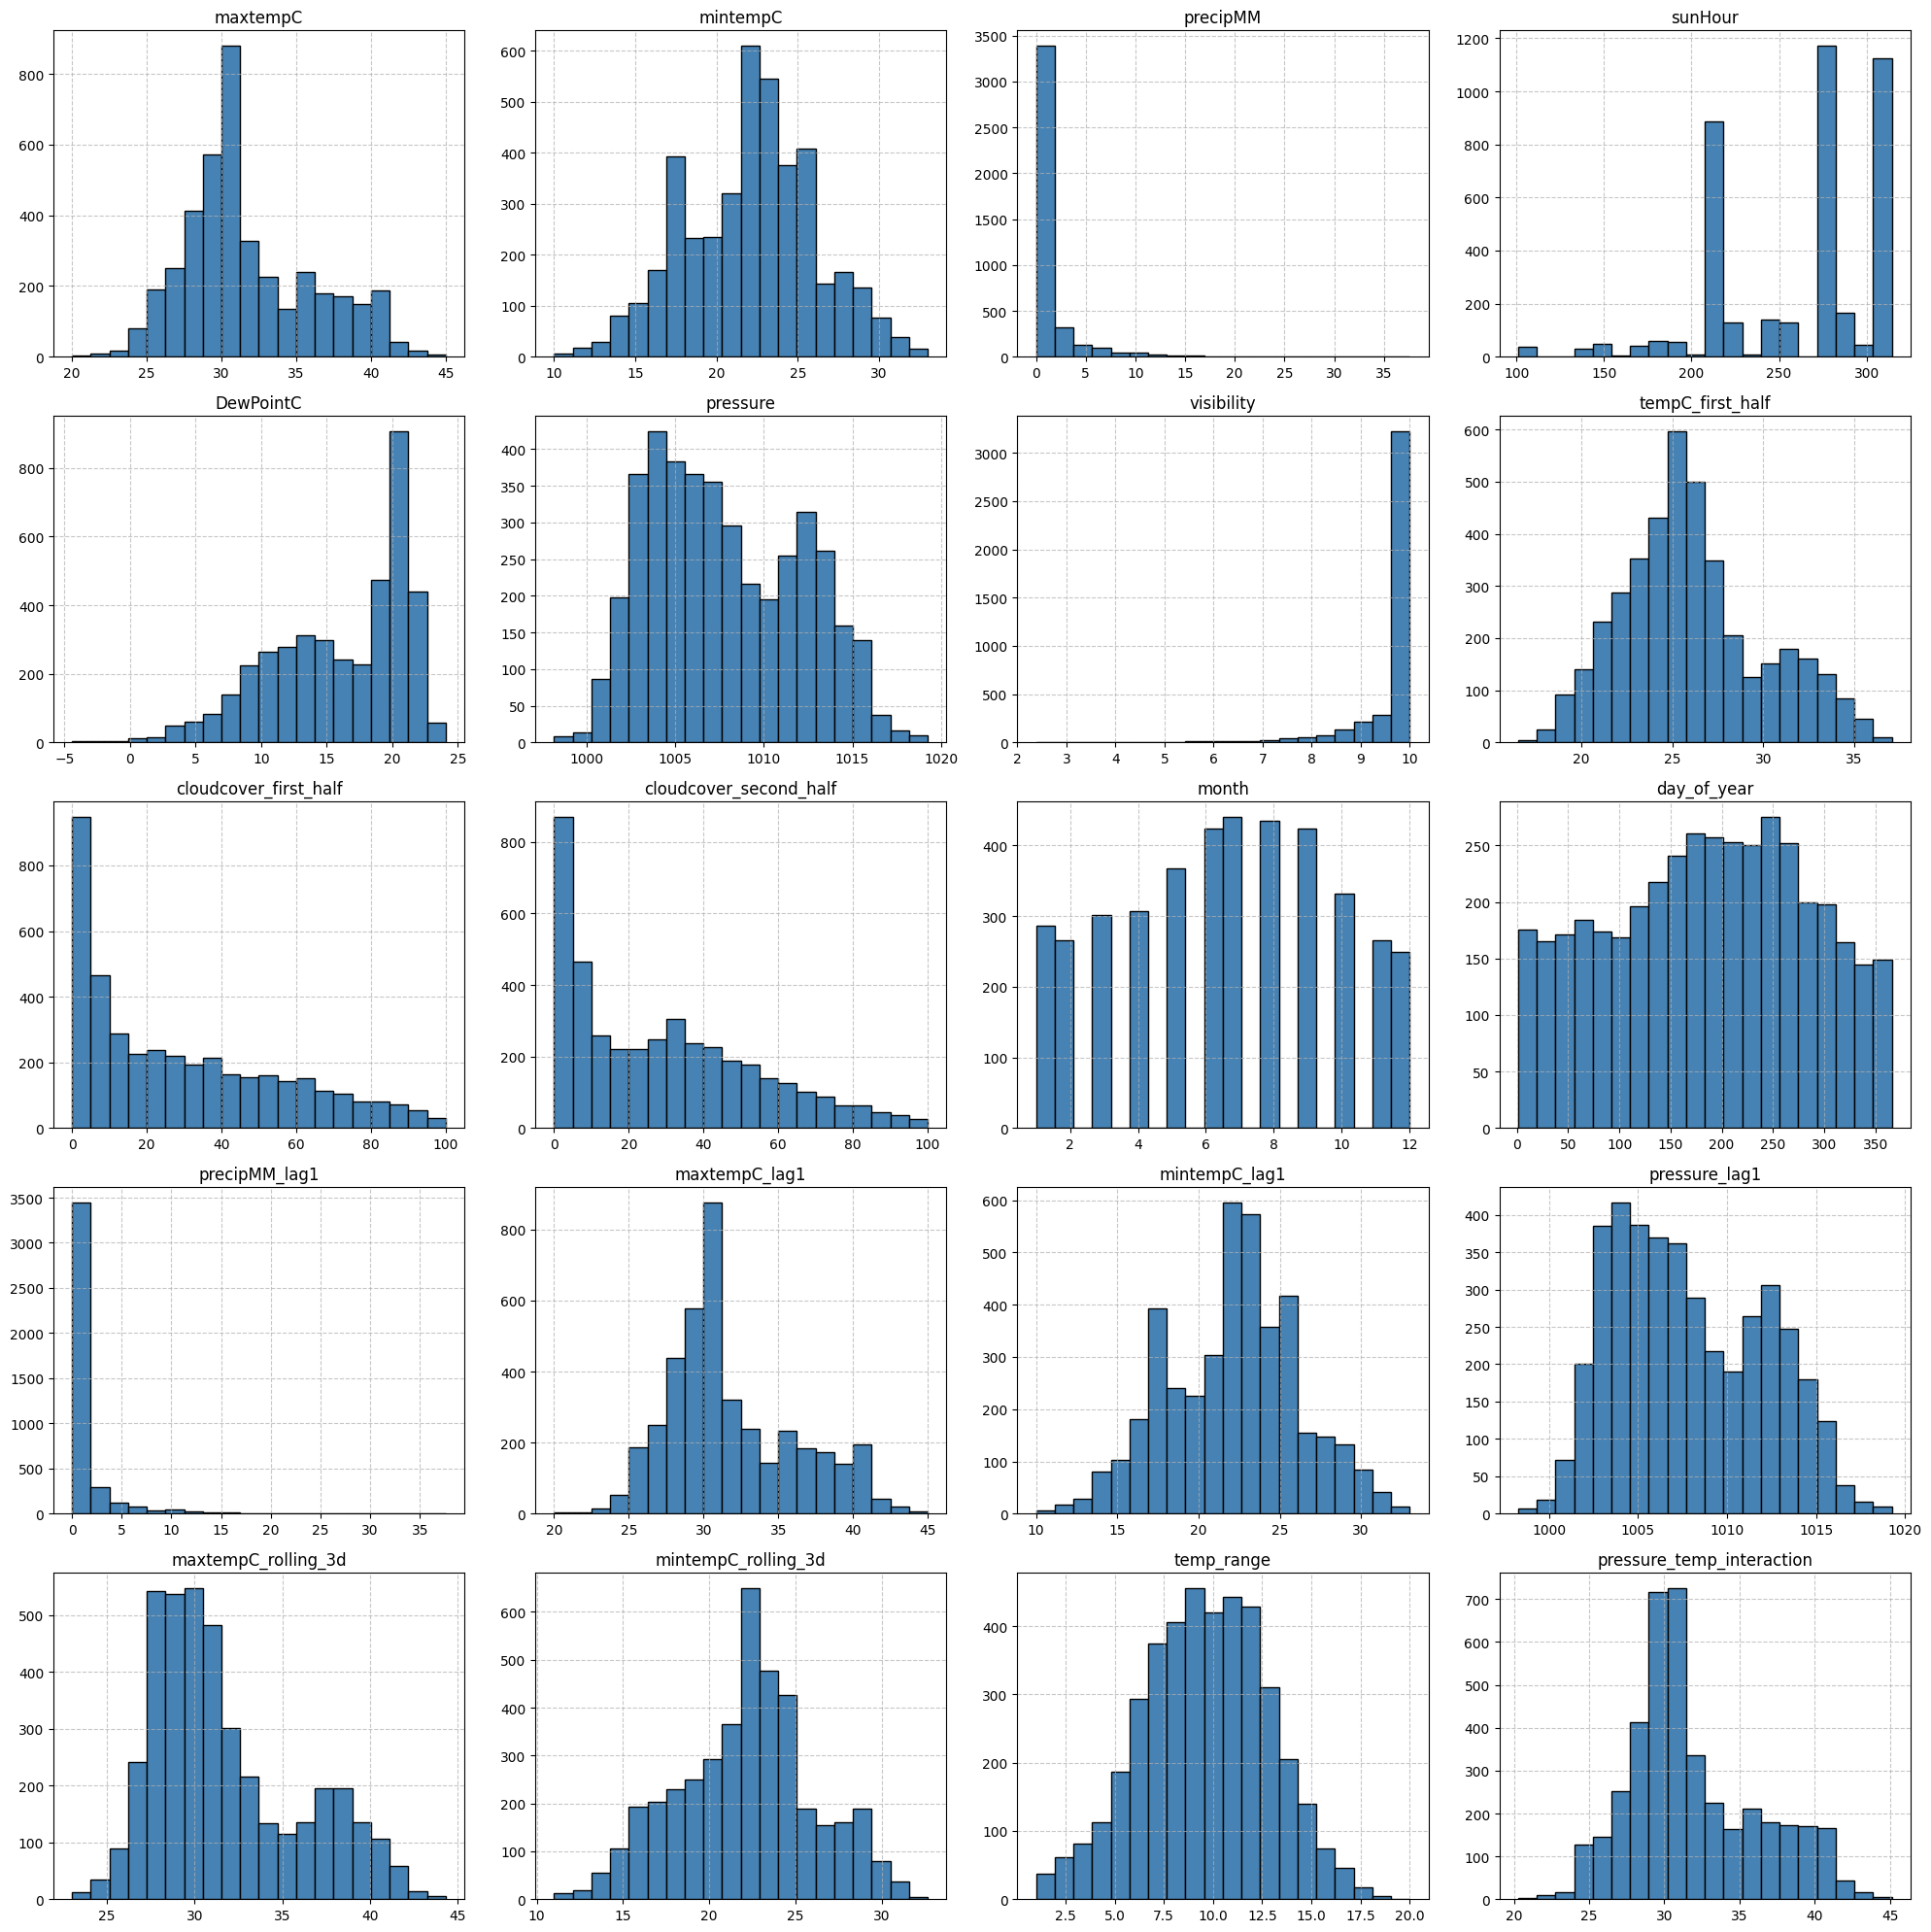

In [31]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Plot histogram for each feature
for i, feature in enumerate(X_train_selected_df.columns):
    if i < len(axes):
        axes[i].hist(X_train_selected_df[feature], bins=20, color='steelblue', edgecolor='black')
        axes[i].set_title(feature)
        axes[i].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [32]:
# Features for MinMax scaling (bounded/categorical)
minmax_features = ['sunHour', 'cloudcover_first_half', 'cloudcover_second_half', 
                  'month', 'day_of_year']

# Features for Standard scaling (normal distributions)  
standard_features = ['maxtempC', 'mintempC', 'pressure', 'DewPointC', 'tempC_first_half',
                   'maxtempC_lag1', 'mintempC_lag1', 'pressure_lag1', 
                   'maxtempC_rolling_3d', 'mintempC_rolling_3d', 'temp_range',
                   'pressure_temp_interaction']

# Features for Log transformation (skewed)
log_features = ['precipMM', 'visibility', 'precipMM_lag1']

# Filter to only include features that are actually selected
selected_feature_names = list(X_train_selected_df.columns)
minmax_features = [f for f in minmax_features if f in selected_feature_names]
standard_features = [f for f in standard_features if f in selected_feature_names] 
log_features = [f for f in log_features if f in selected_feature_names]

# Add any unassigned features to standard scaling
assigned = set(minmax_features + standard_features + log_features)
unassigned = [f for f in selected_feature_names if f not in assigned]
standard_features.extend(unassigned)

# Create preprocessor
preprocessor = ColumnTransformer([
   ('minmax', make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler()), minmax_features),
   ('standard', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), standard_features),
   ('log', make_pipeline(SimpleImputer(strategy='median'), FunctionTransformer(np.log1p, validate=True)), log_features)
])


In [33]:
# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train_selected_df)
X_test_p = preprocessor.transform(X_test_selected_df)
y_train_p = y_train_resampled
y_test_p = y_test


In [34]:
X_train_p,y_train_p

(array([[0.505618  , 0.1358    , 0.1533    , ..., 0.        , 2.39789527,
         0.        ],
        [0.505618  , 0.0583    , 0.055     , ..., 0.        , 2.39789527,
         0.        ],
        [0.505618  , 0.0083    , 0.0283    , ..., 0.        , 2.39789527,
         0.        ],
        ...,
        [0.37078652, 0.64264809, 0.85041298, ..., 1.87876035, 2.23062797,
         1.45601793],
        [1.        , 0.34613064, 0.26486761, ..., 0.54566024, 2.38675821,
         0.77324692],
        [0.97774374, 0.46400776, 0.47595264, ..., 0.        , 2.39789527,
         0.        ]]),
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 4093    1
 4094    1
 4095    1
 4096    1
 4097    1
 Name: Raintomorrow, Length: 4098, dtype: int64)

## **4.Models**

### **4.1 SVC** 

In [37]:
from sklearn.metrics import classification_report
model = SVC(
    C=10.0,
    kernel='rbf',
    gamma='scale',
    probability=True,  # Enable probability for ensemble later
    random_state=42
)

# Train the model
model.fit(X_train_p, y_train_p)

# Make predictions
y_pred = model.predict(X_test_p)
y_pred_proba = model.predict_proba(X_test_p)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_p, y_pred)
f1_svc = f1_score(y_test_p, y_pred)

print("SVC Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_svc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_p, y_pred))

SVC Results:
Accuracy: 0.8107
F1 Score: 0.7690

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       493
           1       0.73      0.82      0.77       310

    accuracy                           0.81       803
   macro avg       0.80      0.81      0.80       803
weighted avg       0.82      0.81      0.81       803



In [38]:
f1_score(y_test_p,y_pred)

0.7689969604863222

In [39]:
import xgboost as xgb

print("=== XGBoost Model ===")

# XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train_p, y_train_p)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_p)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_p)[:, 1]

# Evaluate
accuracy_xgb = accuracy_score(y_test_p, y_pred_xgb)
f1_xgb = f1_score(y_test_p, y_pred_xgb)

print("XGBoost Results:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_p, y_pred_xgb))

=== XGBoost Model ===
XGBoost Results:
Accuracy: 0.8394
F1 Score: 0.7909

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       493
           1       0.79      0.79      0.79       310

    accuracy                           0.84       803
   macro avg       0.83      0.83      0.83       803
weighted avg       0.84      0.84      0.84       803



In [40]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from imblearn.ensemble import BalancedRandomForestClassifier

print("=== Random Forest ===")

# Enhanced Random Forest
rf_model = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_p, y_train_p)

# Make predictions
y_pred_rf = rf_model.predict(X_test_p)
y_pred_proba_rf = rf_model.predict_proba(X_test_p)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test_p, y_pred_rf)
f1_rf = f1_score(y_test_p, y_pred_rf)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"OOB Score: {rf_model.oob_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_p, y_pred_rf))

# Quick hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=BalancedRandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_p, y_train_p)
best_rf_model = random_search.best_estimator_

print("Best RF Parameters:", random_search.best_params_)
print("Best CV F1 Score:", random_search.best_score_)

# Evaluate best RF
y_pred_p = best_rf_model.predict(X_test_p)
f1_best_rf = f1_score(y_test_p, y_pred_p)

print(f"Best RF Test F1 Score: {f1_best_rf:.4f}")

=== Random Forest ===
Random Forest Results:
Accuracy: 0.8381
F1 Score: 0.7950
OOB Score: 0.8636

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       493
           1       0.78      0.81      0.79       310

    accuracy                           0.84       803
   macro avg       0.83      0.83      0.83       803
weighted avg       0.84      0.84      0.84       803

Best RF Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best CV F1 Score: 0.8477866489243735
Best RF Test F1 Score: 0.7969


In [41]:

from sklearn.ensemble import VotingClassifier

print("=== Ensemble Model ===")

# Create ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('svc', model),
        ('xgb', xgb_model), 
        ('rf', best_rf_model)
    ],
    voting='soft'
)

# Train ensemble
ensemble_model.fit(X_train_p, y_train_p)

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test_p)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_p)[:, 1]

# Evaluate
accuracy_ensemble = accuracy_score(y_test_p, y_pred_ensemble)
f1_ensemble = f1_score(y_test_p, y_pred_ensemble)

print("Ensemble Results:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"F1 Score: {f1_ensemble:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_p, y_pred_ensemble))

=== Ensemble Model ===
Ensemble Results:
Accuracy: 0.8431
F1 Score: 0.8019

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       493
           1       0.78      0.82      0.80       310

    accuracy                           0.84       803
   macro avg       0.83      0.84      0.84       803
weighted avg       0.85      0.84      0.84       803



In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

print("=== TensorFlow Neural Network with Training Tracking ===")

# Set random seed for reproducibility
tf.random.set_seed(42)

# Build the neural network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_p.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(), 
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

# Print model architecture
print("Neural Network Architecture:")
nn_model.summary()

# Compile the model
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks with more tracking
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=8, 
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model with verbose output
print("Training Neural Network...")
print(f"Training samples: {X_train_p.shape[0]}")
print(f"Features: {X_train_p.shape[1]}")
print(f"Starting training for up to 100 epochs...")

history = nn_model.fit(
    X_train_p, y_train_p,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1  # Show progress for each epoch
)

=== TensorFlow Neural Network with Training Tracking ===
Neural Network Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                    

In [43]:
from sklearn.metrics import classification_report

y_pred_proba_nn = nn_model.predict(X_test_p, verbose=0).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

# Evaluate
accuracy_nn = accuracy_score(y_test_p, y_pred_nn)
f1_nn = f1_score(y_test_p, y_pred_nn)

print("TensorFlow Neural Network Results:")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_p, y_pred_nn))

TensorFlow Neural Network Results:
Accuracy: 0.8568
F1 Score: 0.8118

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       493
           1       0.82      0.80      0.81       310

    accuracy                           0.86       803
   macro avg       0.85      0.85      0.85       803
weighted avg       0.86      0.86      0.86       803



In [44]:
# Results Comparison - NEW MODELS ONLY
print("=== FINAL RESULTS COMPARISON ===")

results = {
    'SVC': f1_svc,
    'XGBoost': f1_xgb, 
    'Enhanced RF': f1_rf,
    'Best RF (Tuned)': f1_best_rf,
    'Ensemble': f1_ensemble,
    'Neural Network' : f1_nn
    
}

print("F1 Score Results:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")

# Find best model
best_model_name = max(results, key=results.get)
best_score = results[best_model_name]

print(f"\n Best Performing Model: {best_model_name}")
print(f" Best F1 Score: {best_score:.4f}")

=== FINAL RESULTS COMPARISON ===
F1 Score Results:
SVC: 0.7690
XGBoost: 0.7909
Enhanced RF: 0.7950
Best RF (Tuned): 0.7969
Ensemble: 0.8019
Neural Network: 0.8118

 Best Performing Model: Neural Network
 Best F1 Score: 0.8118
